In [1]:
# installing tensorflow_text 
!pip install tensorflow_text  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
# importing required libraries
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# using builtin implementations
use_builtins = True

In [4]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [5]:
# reading dataset and making two lists of hinglish and english senetnces
file = open('/kaggle/input/anuvaad/anuvaad.txt','r')
# print(file.read())
# lst=targ, lst2=inp
fileStrings = file.readlines()
targ = []
inp = []
for line in fileStrings:
    # print(line)
    line = line.replace('\n','')
    lstO = line.split('\t')
    targ.append(lstO[0])
    inp.append(lstO[1])
print(targ)
print(inp)

['Come on boys, it is time to shine.', 'This heart asks for more!', 'She was roasting the spices when the phone rang', 'You know me right', 'I will handle that', 'Come over to my place, we will sit together and drink tea', 'this is a sample', 'I hope I have made you understand well', 'Why is it late? What is your excuse?', 'I get milk for free', 'yes there it is', 'dude I made a mistake', 'Oh do not you know Hinglish? Wait, I will teach you', 'You naughty boy, I will teach you a lesson', 'How are you? I hope everything is going well.', 'Bring some fruits and vegetables', '17 Ways to Increase WordPress Site Speed', 'she only keeps doing timepass', 'we are going to visit tomorrow', 'See you tomorrow afternoon at 3pm', "I am going to visit Shobha, Ravi's would be", 'she is completely filmy', "At the time of the bride's farewell, there was a complete filmy atmosphere.", "Today's movie was just a time-pass.", 'Tell me your number', 'Punit is absolutely an useless man', 'Seema, you are looki

In [6]:
# printing last english sentence
print(targ[-1])

most best friend


In [7]:
# printing first 100 english sentence
print(targ[:100])

['Come on boys, it is time to shine.', 'This heart asks for more!', 'She was roasting the spices when the phone rang', 'You know me right', 'I will handle that', 'Come over to my place, we will sit together and drink tea', 'this is a sample', 'I hope I have made you understand well', 'Why is it late? What is your excuse?', 'I get milk for free', 'yes there it is', 'dude I made a mistake', 'Oh do not you know Hinglish? Wait, I will teach you', 'You naughty boy, I will teach you a lesson', 'How are you? I hope everything is going well.', 'Bring some fruits and vegetables', '17 Ways to Increase WordPress Site Speed', 'she only keeps doing timepass', 'we are going to visit tomorrow', 'See you tomorrow afternoon at 3pm', "I am going to visit Shobha, Ravi's would be", 'she is completely filmy', "At the time of the bride's farewell, there was a complete filmy atmosphere.", "Today's movie was just a time-pass.", 'Tell me your number', 'Punit is absolutely an useless man', 'Seema, you are looki

In [8]:
# printing first 100 hinglish sentences
print(inp[-1:])

['best friend sabse']


In [9]:
# arrays of strings are shuffled and batches are made
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'bhai kon dhyan dera hai waise bhi'
 b'And fir coursera pe jake ke enroll kar through that email..'
 b'Thand bhi nahi tha..par garmi bhi nahi thi'
 b'Hum do din k liye Jaipur ghumne jaa rhe h.'
 b'For FENirali publication ki pdf send kro'], shape=(5,), dtype=string)

tf.Tensor(
[b'Brother, who is paying attention anyway'
 b'And then go to Coursera and enroll through that email'
 b'there was no cold..nor hot'
 b'We are going to visit Jaipur for two days.'
 b'Send pdf of FE Nirali publication'], shape=(5,), dtype=string)


In [11]:
# unicode normalization operation - first step to standardize data
example_text = tf.constant('Yahi haal hai')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Yahi haal hai'
b'Yahi haal hai'


In [12]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Yahi haal hai
[START] yahi haal hai [END]


In [14]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(    # handles vocabulary extraction & conversion of i/p text to sequences of tokens
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [15]:
input_text_processor.adapt(inp)    # initializes the layer based on the data

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]
# Hinglish TextVectorization layer

['', '[UNK]', '[START]', '[END]', 'hai', '.', '?', 'hain', ',', 'kya']

In [16]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]
# English TextVectorization layer

['', '[UNK]', '[START]', '[END]', '.', 'the', 'is', 'i', ',', 'you']

In [17]:
# the above layers convert a batch of strings into a batch of token IDs
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   38,  210,  919, 1893,    4,  701,   17,    3,    0],
       [   2,   74,  139,  660,   70, 1669,   13,  907,   36, 1121],
       [   2, 1137,   17,   26,   22,    5,    5,   71,  159,   17]])>

In [18]:
# get_vocabulary - converts token IDs back to text
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] bhai kon dhyan dera hai waise bhi [END]           '

Text(0.5, 1.0, 'Mask')

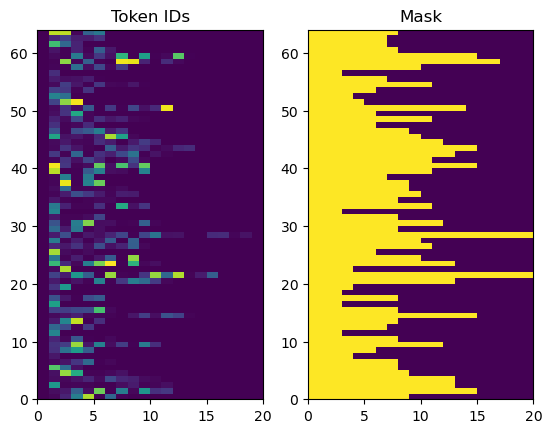

In [19]:
# token IDs converted into a mask
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [20]:
# defining constants for the model
embedding_dim = 256
units = 1024

Encoding

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                  recurrent_dropout=0.3)

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [22]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 1024)
Encoder state, shape (batch, units): (64, 1024)


Attention layer

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [24]:
# creating BahdanauAttention layer
attention_layer = BahdanauAttention(units)

In [25]:
(example_tokens != 0).shape

TensorShape([64, 20])

In [26]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 20)


Text(0.5, 1.0, 'Mask')

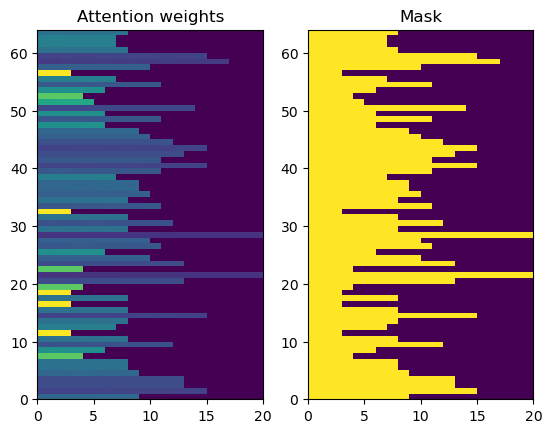

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [28]:
attention_weights.shape

TensorShape([64, 2, 20])

In [29]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 640x480 with 0 Axes>

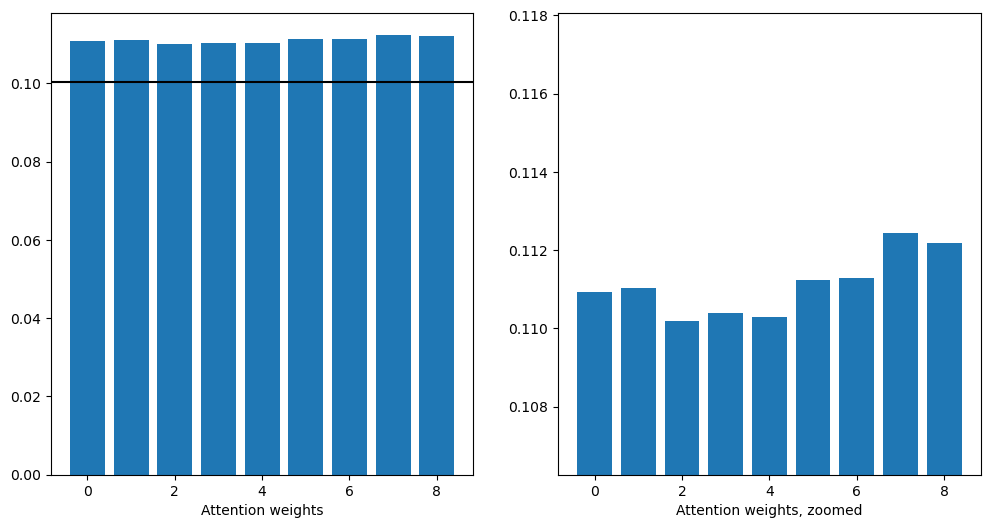

In [30]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

Decoder

In [31]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                  recurrent_dropout=0.3)

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [32]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [33]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [34]:
Decoder.call = call

In [35]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [36]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [37]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 1215)
state shape: (batch_size, dec_units) (64, 1024)


In [38]:
# sample token according to logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [39]:
# decode the token as first word of o/p
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['cse'],
       ['chemistry'],
       ['development'],
       ['mcq'],
       ['amitabh']], dtype='<U15')

In [40]:
# decoder generates second set of logits
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [41]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['active'],
       ['loop'],
       ['if'],
       ['rupees'],
       ['whatb']], dtype='<U15')

Training

In [42]:
# Loss function definition
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [43]:
# implementing training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [44]:
# Receiving batches of english & hinglish data
# Converting those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [45]:
TrainTranslator._preprocess = _preprocess

In [46]:
# training
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [47]:
TrainTranslator._train_step = _train_step

In [48]:
# executes the decoder and calculates the incremental loss and new decoder state 
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [49]:
TrainTranslator._loop_step = _loop_step

In [50]:
# testing the training step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [51]:
np.log(output_text_processor.vocabulary_size())

7.102499355774649

In [52]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.3215303>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.2863216>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.2156024>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.9951086>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.203402>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=10.754562>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.398326>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.052758>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.351235>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.3675904>}

CPU times: user 34.4 s, sys: 1.63 s, total: 36.1 s
Wall time: 35 s


In [53]:
# maximizing performance while training
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [54]:
TrainTranslator._tf_train_step = _tf_train_step

In [55]:
translator.use_tf_function = True

In [56]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2235956>}

In [57]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.943525>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6375957>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9657283>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5299997>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.490325>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.488968>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.478317>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4534583>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.415429>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.366076>}

CPU times: user 5.36 s, sys: 573 ms, total: 5.93 s
Wall time: 3.84 s


....................................................................................................


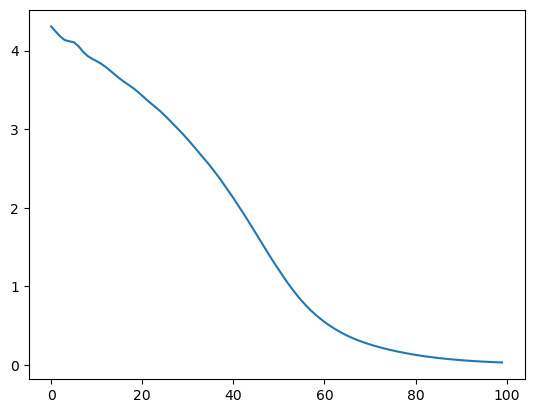

In [58]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [59]:
# building a fresh copy of the model to train from scratch since the training step is working
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Training the model

In [60]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [61]:
train_translator.fit(dataset, epochs=100,
                     callbacks=[batch_loss])

Epoch 1/100
21/21 [==============================] - 20s 588ms/step - batch_loss: 5.3177
Epoch 2/100
21/21 [==============================] - 10s 489ms/step - batch_loss: 4.6296
Epoch 3/100
21/21 [==============================] - 10s 493ms/step - batch_loss: 4.3310
Epoch 4/100
21/21 [==============================] - 9s 443ms/step - batch_loss: 3.9381
Epoch 5/100
21/21 [==============================] - 9s 411ms/step - batch_loss: 3.4900
Epoch 6/100
21/21 [==============================] - 10s 456ms/step - batch_loss: 2.9612
Epoch 7/100
21/21 [==============================] - 9s 415ms/step - batch_loss: 2.4372
Epoch 8/100
21/21 [==============================] - 9s 414ms/step - batch_loss: 1.9701
Epoch 9/100
21/21 [==============================] - 9s 441ms/step - batch_loss: 1.5955
Epoch 10/100
21/21 [==============================] - 10s 460ms/step - batch_loss: 1.2438
Epoch 11/100
21/21 [==============================] - 9s 425ms/step - batch_loss: 0.9775
Epoch 12/100
21/21 [=====

Text(0, 0.5, 'CE/token')

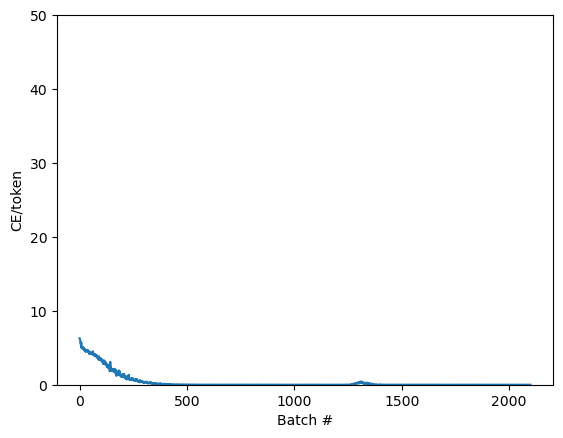

In [62]:
plt.plot(batch_loss.logs)
plt.ylim([0, 50])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

Translation

In [63]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [64]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [65]:
# converting token IDs to human readable text
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [66]:
Translator.tokens_to_text = tokens_to_text

In [67]:
# inputting random token IDs to see what it generates
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'again gb', b'literally semi', b'try presentation',
       b'ankits movie', b'time boys'], dtype=object)

In [68]:
# takes the decoder's logit outputs and samples token IDs from that distribution
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [69]:
Translator.sample = sample

In [70]:
# testing the function on random i/p
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 54],
       [182],
       [718],
       [674],
       [101]])>

In [71]:
# implementing text to text translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [72]:
Translator.translate = translate_unrolled

In [73]:
# TESTING
input_text = tf.constant([
    'Waise really miss those days...', 
    'Yahi haal hai', 
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

by the way , really miss those days .
that is it .



In [74]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [75]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 19.6 s, sys: 208 ms, total: 19.8 s
Wall time: 19.8 s


In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

by the way , really miss those days .
that is it .

CPU times: user 165 ms, sys: 14.9 ms, total: 180 ms
Wall time: 129 ms


In [77]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [78]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [79]:
# RUN THIS
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

by the way , really miss those days .
that is it .



But when you wrap it in a `tf.function` you'll notice two differences.

In [80]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [81]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.88 s, sys: 17.1 ms, total: 1.9 s
Wall time: 1.88 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

by the way , really miss those days .
that is it .

CPU times: user 53.8 ms, sys: 8.02 ms, total: 61.8 ms
Wall time: 42.4 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [83]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         0.99999994 0.99999994 1.0000001  1.         1.
 1.         1.0000001  1.0000001  1.0000001 ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

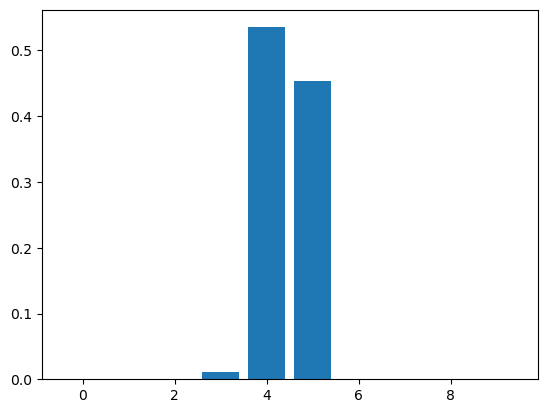

In [84]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

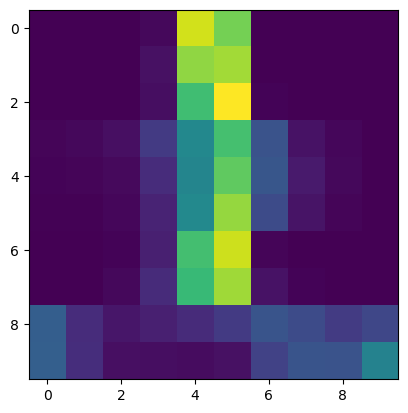

In [85]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [86]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


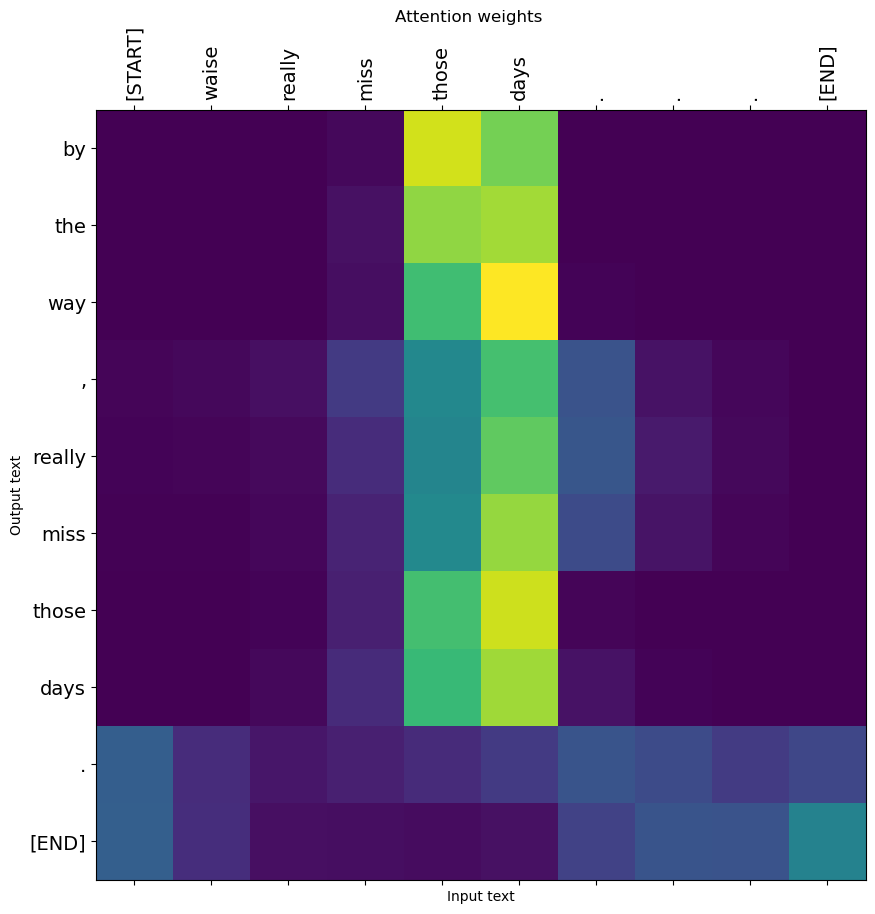

In [87]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [88]:
%%time
three_input_text = tf.constant(['sabse best friend', 
                                'That toh I know',
                                'She was bhunnoing the masalas jub phone ki ghuntee bugee',
                                'tum batao',
                                'kya karna hai'
])

result = translator.tf_translate(three_input_text)
print(result['text'])
for tr in result['text']:
  print(tr.numpy().decode())

print()

tf.Tensor(
[b'most best friend' b'that i know'
 b'she was roasting the spices when the phone rang' b'oh'
 b'what is your name ?'], shape=(5,), dtype=string)
most best friend
that i know
she was roasting the spices when the phone rang
oh
what is your name ?

CPU times: user 56 ms, sys: 5.09 ms, total: 61.1 ms
Wall time: 49.1 ms


In [89]:
result['text']

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'most best friend', b'that i know',
       b'she was roasting the spices when the phone rang', b'oh',
       b'what is your name ?'], dtype=object)>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


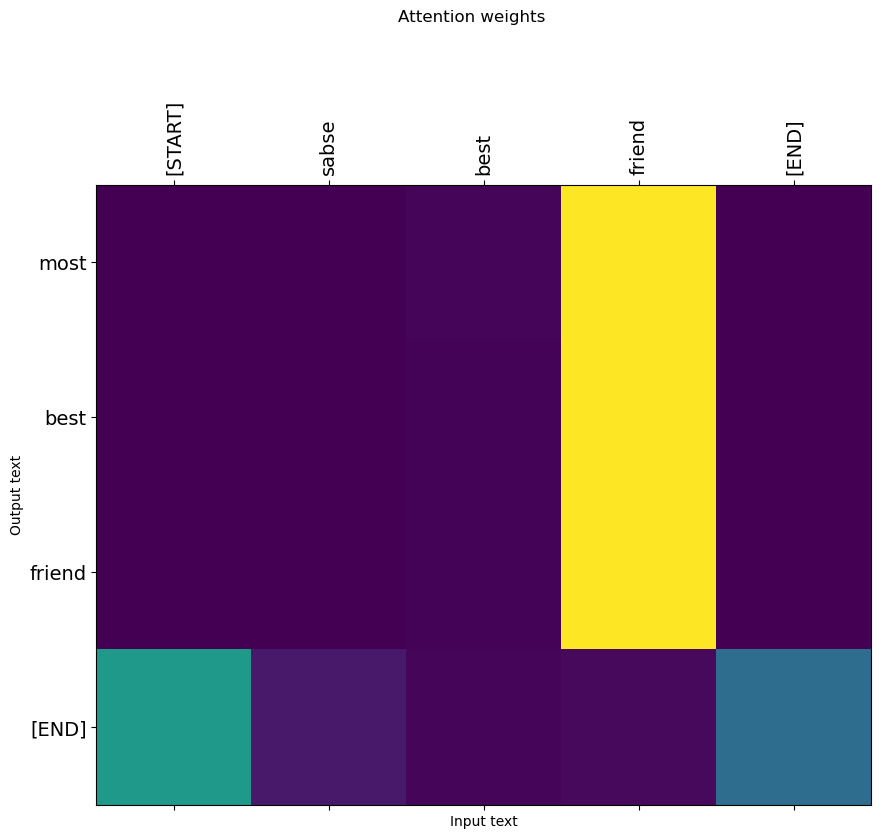

In [90]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


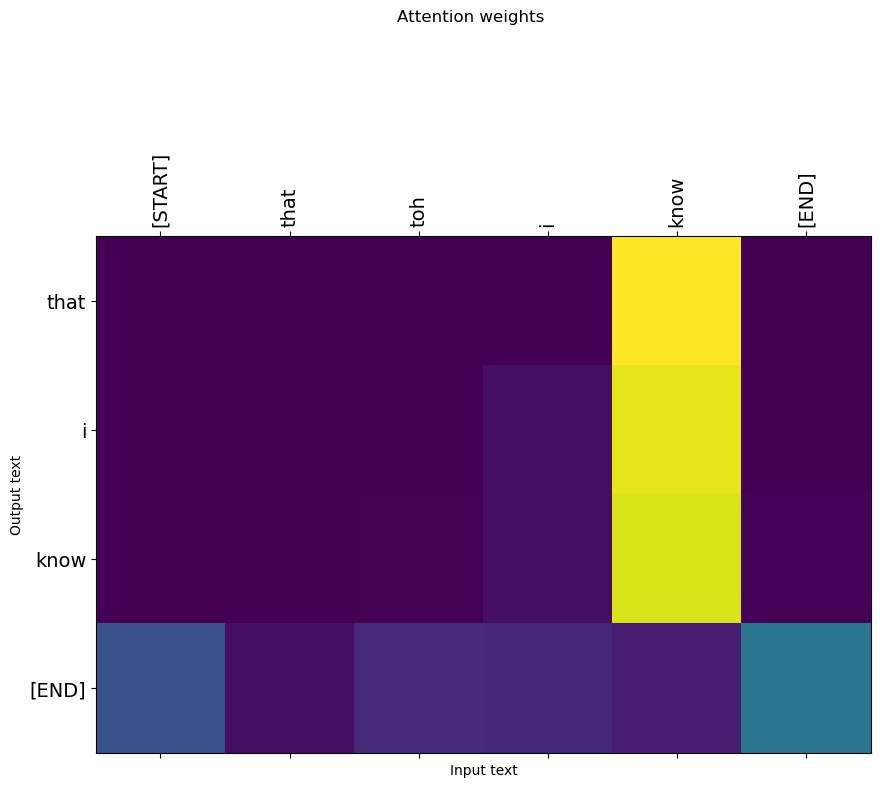

In [91]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


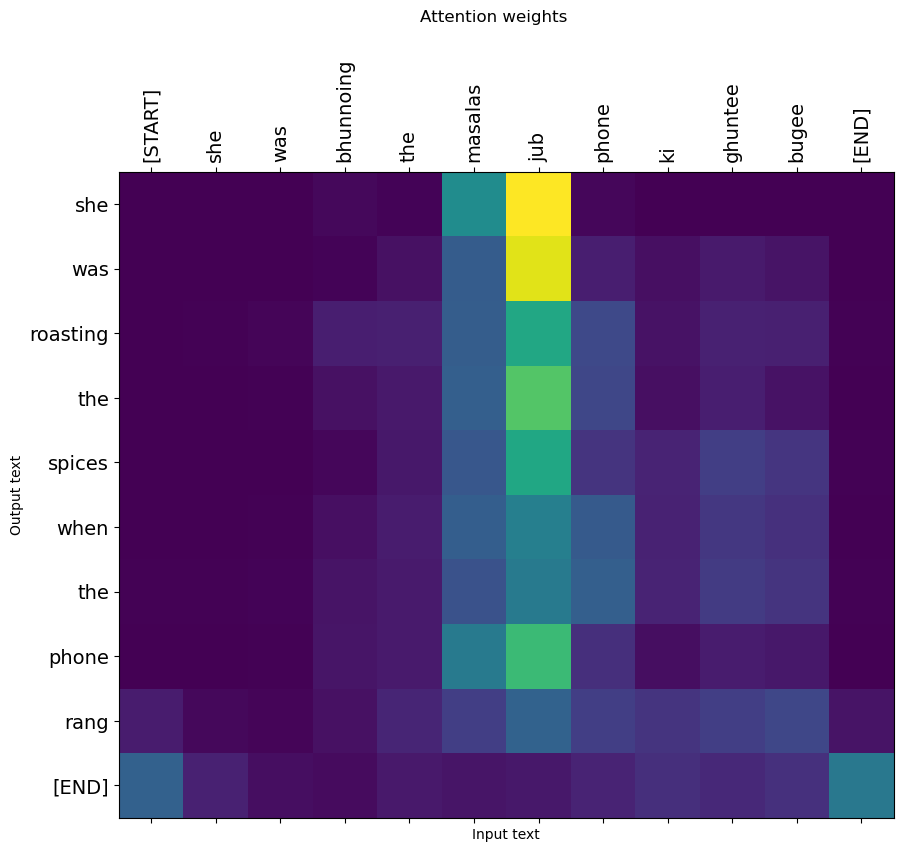

In [92]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [93]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 most best friend


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


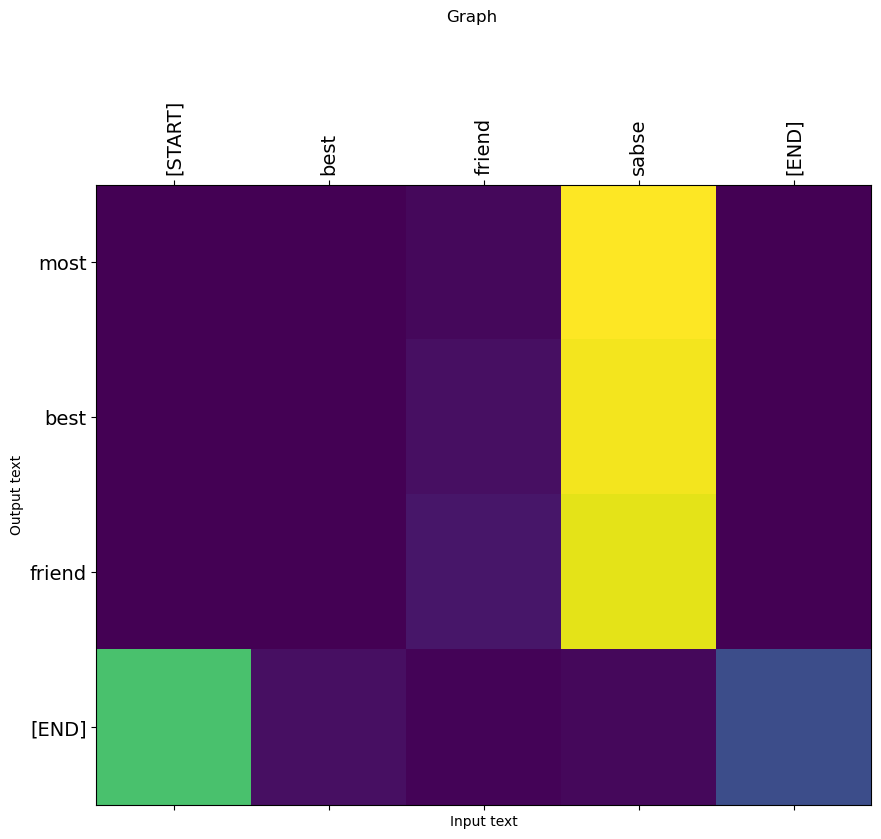

In [94]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('Graph')

In [95]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

In [96]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [97]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

most best friend
that i know
she was roasting the spices when the phone rang
oh tell me
what is the passing

CPU times: user 59.2 ms, sys: 7.47 ms, total: 66.6 ms
Wall time: 46.6 ms


In [98]:
#!zip -r translator.zip translator